In [27]:
import pandas as pd
from sklearn.datasets import fetch_mldata
import torch
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import urllib

In [28]:
test_data = pd.read_csv('../input/test.csv')

# Load labels for trainig datafrom six.moves import urllib
mnist_path = "mnist-original.mat"

# download label test dataset from github.
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)

mnist_raw = loadmat(mnist_path)

X = mnist_raw["data"].T
y = mnist_raw["label"][0].astype(np.long)

X_test = test_data.values

X.shape, X_test.shape

((70000, 784), (28000, 784))

In [29]:
def pairwise_distances(x, y):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_t = torch.transpose(y, 0, 1)
    y_norm = (y**2).sum(1).view(1, -1)
    
    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, np.inf)

In [30]:
%%time
cuda_test = torch.from_numpy(X_test).cuda().float()
cuda_train = torch.from_numpy(X).cuda().float()
ds = torch.utils.data.TensorDataset(cuda_test)
_min_dists = []
_arg_min_dists = []
bs = 1000
for batch, in torch.utils.data.DataLoader(ds, batch_size=bs, pin_memory=False):
    min_dist, arg_min_dist = pairwise_distances(cuda_train, batch).min(0)
    _min_dists.append(min_dist)
    _arg_min_dists.append(arg_min_dist)

CPU times: user 244 ms, sys: 88 ms, total: 332 ms
Wall time: 355 ms


In [31]:
min_dists = torch.cat(_min_dists)
arg_min_dists = torch.cat(_arg_min_dists)
print(f'Number of not found samples: {len(min_dists[min_dists>0])}')

Number of not found samples: 1


In [32]:
sub = pd.read_csv('../input/sample_submission.csv')
sub.Label = y[arg_min_dists.cpu()]
sub.to_csv('sub.csv', index=False)
!head sub.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


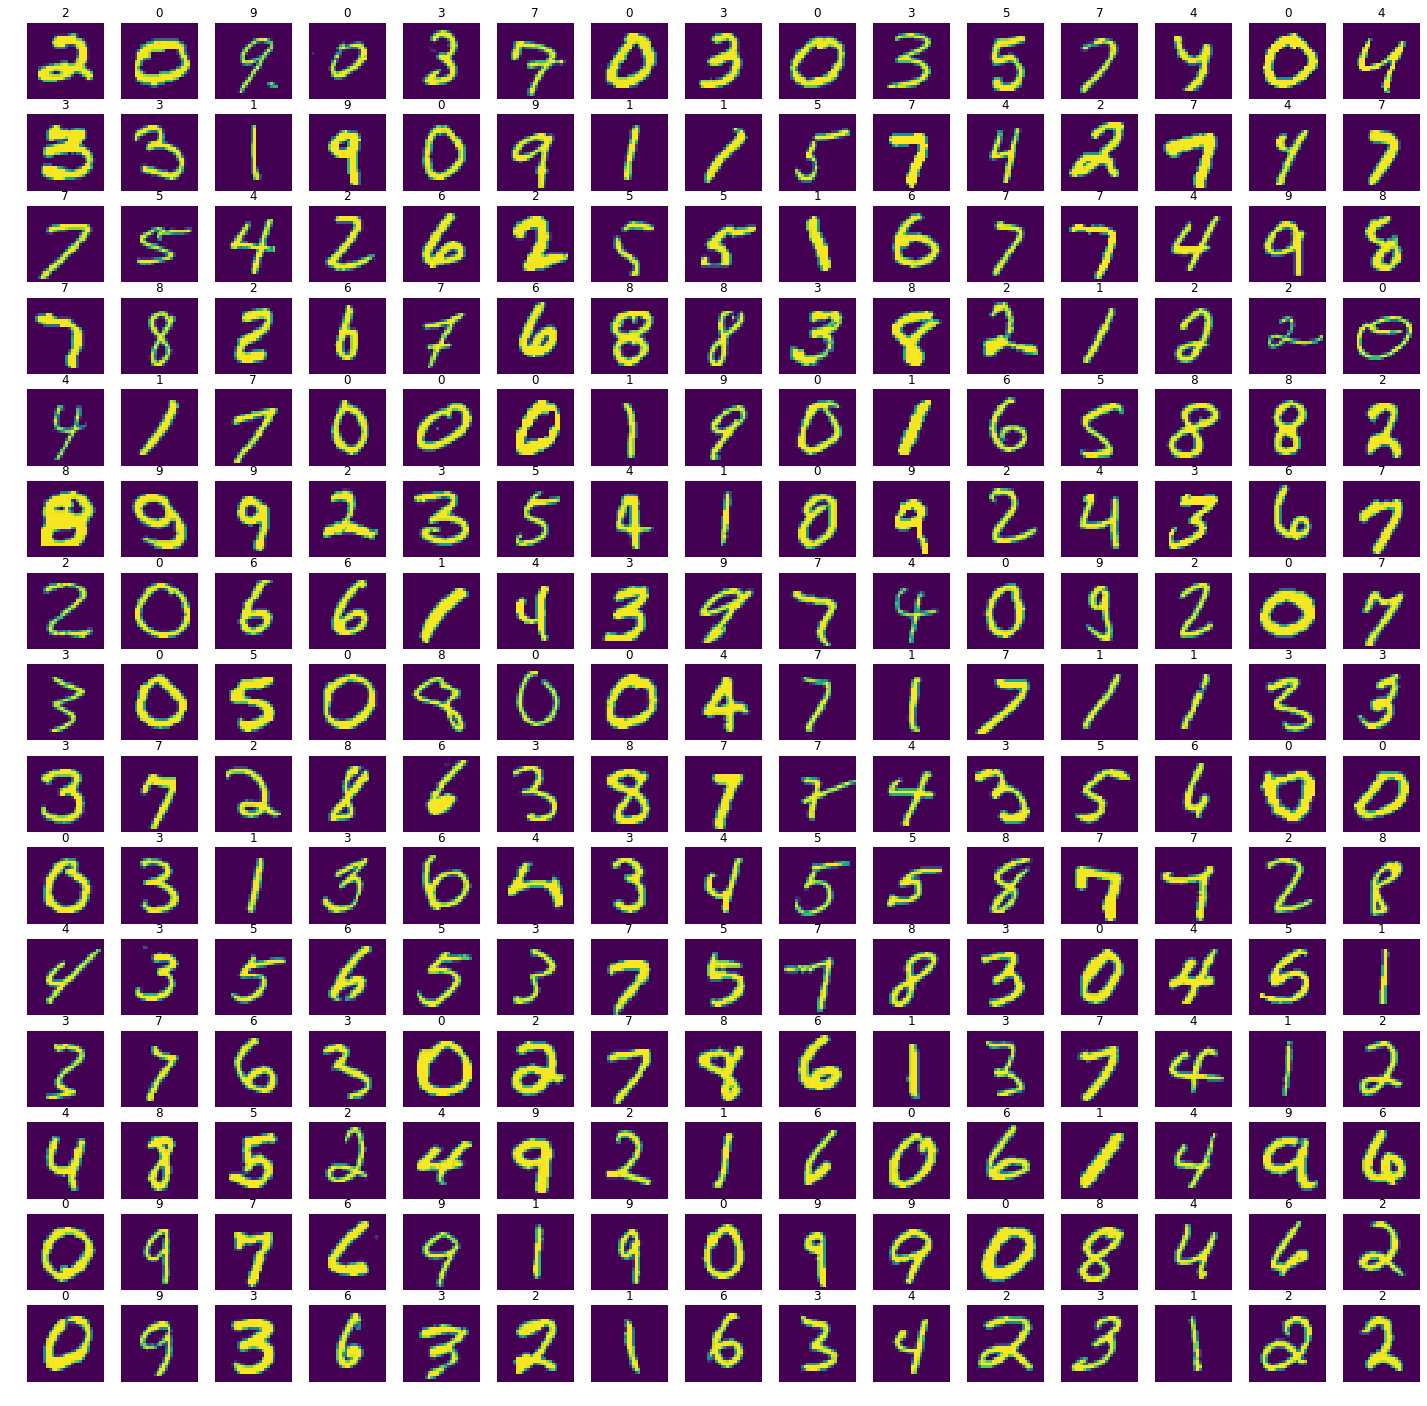

In [33]:
fig, axs = plt.subplots(15, 15, figsize=(25,25))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(sub.Label[i])
    ax.imshow(X_test[i].reshape(28,28))
    ax.axis('off')
